In [13]:
import os, shutil, pathlib

original_dir = pathlib.Path("../../local/dogs_vs_cats/train/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

In [14]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir/fname, dst=dir/fname)


In [15]:
make_subset("train", start_index=0, end_index=1000)

In [17]:
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [18]:
import keras
from keras import layers

inputs = keras.Input(shape=(180,180,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

2024-11-27 09:28:01.717037: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir/ "train",
    image_size = (180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180,180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [25]:
for data_batch, labels_batch in train_dataset:
    print(data_batch.shape, labels_batch.shape)
    break


(32, 180, 180, 3) (32,)


In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [28]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [29]:
history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 466ms/step - accuracy: 0.4798 - loss: 0.6965 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 480ms/step - accuracy: 0.5122 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6985
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 479ms/step - accuracy: 0.5592 - loss: 0.6985 - val_accuracy: 0.5520 - val_loss: 0.6766
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.6019 - loss: 0.6616 - val_accuracy: 0.6470 - val_loss: 0.6308
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step - accuracy: 0.6707 - loss: 0.6060 - val_accuracy: 0.6410 - val_loss: 0.6813
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step - accuracy: 0.6934 - loss: 0.5916 - val_accuracy: 0.6280 - val_loss: 0.7031
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 480ms/step - accuracy: 0.7020 - loss: 0.5687 - val_accuracy: 0.6790 - val_loss: 0.6095
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - accuracy: 0.7403 - loss: 0.5206 - val_accu

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["accuracy", "val_accuracy"]].plot(ax = ax[1], title = "Accuracy", grid = True)

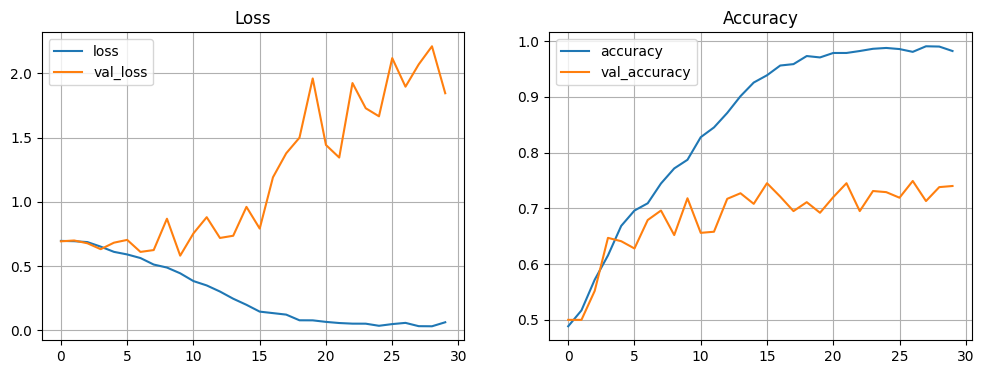

In [34]:

plot_metrics(pd.DataFrame(history.history))

In [35]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.7470 - loss: 0.5463
Test accuracy: 0.737


In [36]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

2024-11-27 10:17:18.352286: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


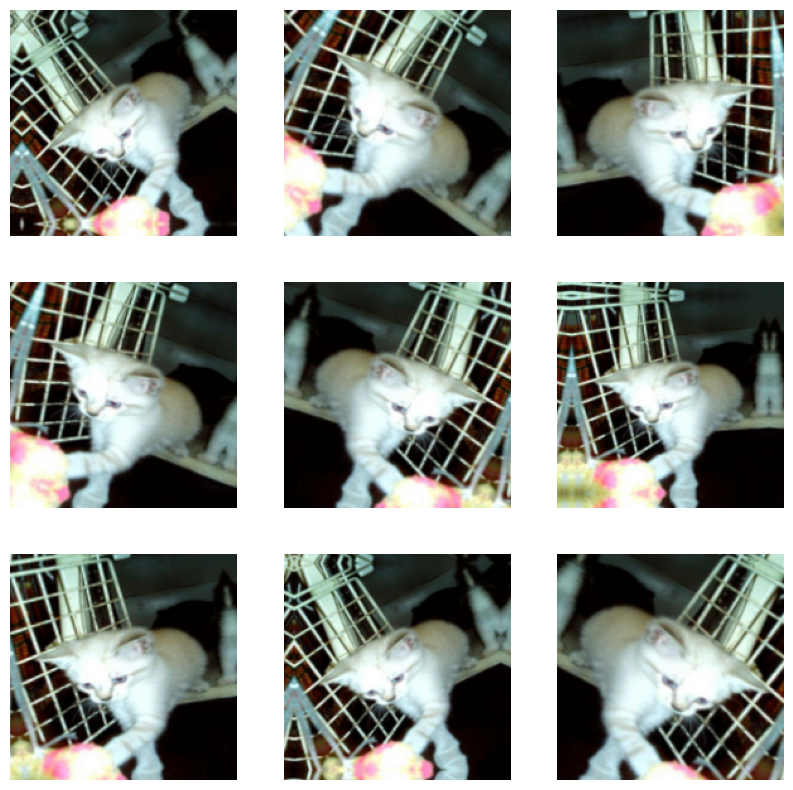

In [38]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [40]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="rmsprop",loss="binary_crossentropy", metrics=["accuracy"])

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [42]:
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.5114 - loss: 0.7211 - val_accuracy: 0.5010 - val_loss: 0.6928
Epoch 2/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - accuracy: 0.5072 - loss: 0.6935 - val_accuracy: 0.5820 - val_loss: 0.6888
Epoch 3/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - accuracy: 0.5432 - loss: 0.6976 - val_accuracy: 0.5220 - val_loss: 0.6835
Epoch 4/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - accuracy: 0.5609 - loss: 0.6865 - val_accuracy: 0.5430 - val_loss: 0.6830
Epoch 5/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - accuracy: 0.5816 - loss: 0.6639 - val_accuracy: 0.5890 - val_loss: 0.6689
Epoch 6/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - accuracy: 0.6001 - loss: 0.6547 - val_accuracy: 0.6130 - val_loss: 0.6498
Epoch 7/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - accuracy: 0.6361 - loss: 0.6324 - val_accuracy: 0.6370 - val_loss: 0.6280
Epoch 8/80
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - accuracy: 0.6552 - loss: 0.6188 - val_accu

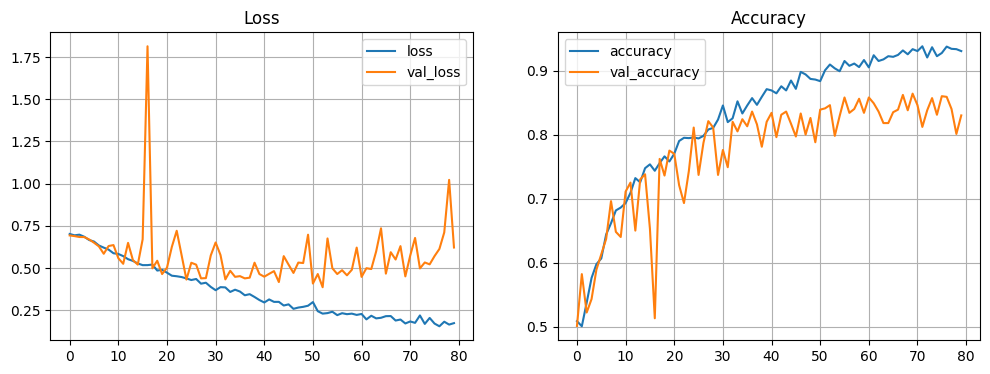

In [44]:
plot_metrics(pd.DataFrame(history.history))

In [45]:
test_model = keras.models.load_model("convnet_from_scracth_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(test_loss, test_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7945 - loss: 0.5241
0.46645447611808777 0.8169999718666077


In [46]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180,180,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [47]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [50]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

2024-11-27 11:33:51.283684: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [51]:
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

In [52]:
history = model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8654 - loss: 57.3581 - val_accuracy: 0.9700 - val_loss: 4.6653
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9726 - loss: 5.2526 - val_accuracy: 0.9560 - val_loss: 7.5195
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9835 - loss: 2.5366 - val_accuracy: 0.9760 - val_loss: 4.2318
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9814 - loss: 1.8847 - val_accuracy: 0.9710 - val_loss: 4.5833
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9913 - loss: 0.7417 - val_accuracy: 0.9730 - val_loss: 4.9642
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9962 - loss: 0.4962 - val_accuracy: 0.9730 - val_loss: 4.7301
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9958 - loss: 0.3417 - val_accuracy: 0.9670 - val_loss: 7.6558
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9968 - loss: 0.4123 - val_accuracy: 0.9730 - 

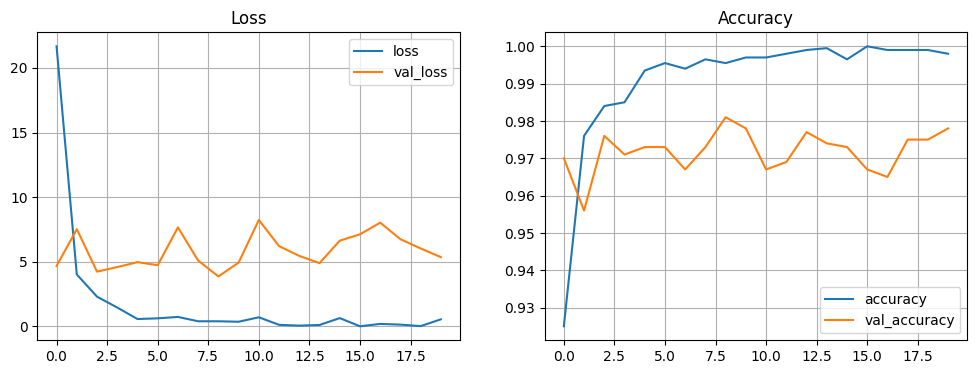

In [53]:
plot_metrics(pd.DataFrame(history.history))

In [57]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(test_loss, test_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9790 - loss: 3.7050
4.936892509460449 0.9739999771118164
